# Imports y configuraciones básicas

Algunos imports que se utilizarán en el resto del notebook

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from bwb.distributions import *
from bwb.utils import plot_list_of_draws, plot_histogram_from_points, freq_labels_posterior

import pandas as pd
import itertools

In [2]:
import logging
log = logging.getLogger("bwb.distributions")
# log.setLevel(logging.INFO)

Importamos los datos del archivo de Google Cloud

In [3]:
data = np.load(r"..\data\face.npy")
data.shape

(161666, 784)

Haremos dos listas de caritas: una sin modificación, y otra con modificación.

In [4]:
%%time

CEIL = 50
n_faces = len(data)
rng = np.random.default_rng(42)


# Builder para hacer las caritas
dist_draw_builder = DistributionDrawBuilder(
    seed=rng,
)

# Conjunto de caritas originales (distintos soportes)
faces_original = list()
for i in range(n_faces):
    arr = 255 - data[i, :].reshape(28, 28)
    dd_arr = dist_draw_builder.create_fromarray(arr)
    faces_original.append(dd_arr)
    
    
# Conjuntos de caritas con soporte no-nulo
dist_draw_builder.set_ceil(CEIL)
    
faces_modified = list()
for i in range(n_faces):
    arr = 255 - data[i, :].reshape(28, 28)
    dd_arr = dist_draw_builder.create_fromarray(arr)
    faces_modified.append(dd_arr)
    
len(faces_original), len(faces_modified)

CPU times: total: 9.02 s
Wall time: 9.04 s


(161666, 161666)

`faces_original` son las caritas sin modificar el soporte, mientras que `faces_modified` es con los que tiene soporte no-nulo.

In [5]:
plot_list_of_draws(faces_original)

In [6]:
plot_list_of_draws(faces_modified)

Obtendremos la data $D = \{x_i\}_{i=1}^{n}\subseteq\mathcal{X}^n$, y probaremos los métodos para distintos valores de $n$.

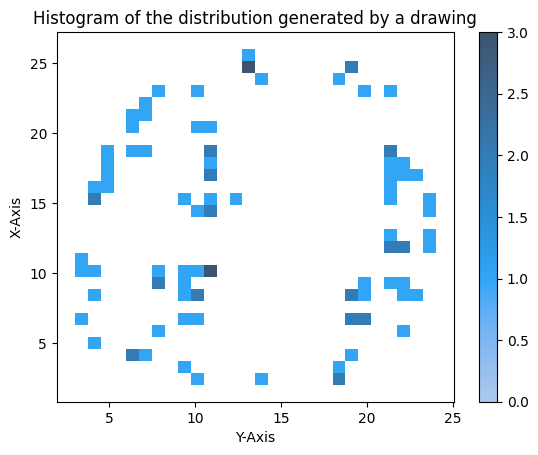

In [7]:
first_face = DistributionDraw.fromarray(
    255 - data[0, :].reshape(28, 28),
    seed=42
)

x = first_face.rvs(size=100)

plot_histogram_from_points(x, histplot_kwargs=dict(bins=28))
plt.show()

# Experimento correr MCMC largo tiempo

In [8]:
import time

tic = time.time()
mcmc = GibbsPosteriorPiN(data=x[:10], models=faces_modified, seed=rng)
toc = time.time()

print(f"Tiempo cálculo de caché: {toc - tic:.4f} [seg]")

tic, toc = time.time(), time.time()

TIEMPO_TOTAL = 3_600 * 2

while toc - tic <= TIEMPO_TOTAL:
    mcmc.draw()
    toc = time.time()

Tiempo cálculo de caché: 6.9781 [seg]


421529

In [12]:
print(f"Número de muestreos después de dos horas: {mcmc.counter.total()}")
print(f"Número de muestreos por segundo: {mcmc.counter.total() / (toc - tic):.4f}")
print(f"Número de muestreos diferentes: {len(mcmc.counter)}")

Número de muestreos después de dos horas: 421529
Número de muestreos por segundo: 58.5456
Número de muestreos diferentes: 41058


In [10]:
plot_list_of_draws(mcmc.most_common(), labels=freq_labels_posterior(mcmc))

# Probando clase `MetropolisPosteriorPiN` datos originales

En esta sección se intentará simular la implementación del algoritmo de *Metropolis* programado en el notebook 05.

In [8]:
%%time
mcmc = MetropolisPosteriorPiN(data=x[:10], models=faces_original, seed=rng)

CPU times: total: 6.61 s
Wall time: 6.61 s


Muestreamos a partir de de esta instancia.

In [9]:
%%time
mcmc.rvs(size=1_000)
mcmc

CPU times: total: 17.2 s
Wall time: 17.2 s


MetropolisPosteriorPiN(n_data=10, n_models=161666, n_samples=1000, last_i=93601)

Y mostramos las caras en orden de la más común a la menos común

In [10]:
plot_list_of_draws(mcmc.most_common(), labels=freq_labels_posterior(mcmc))

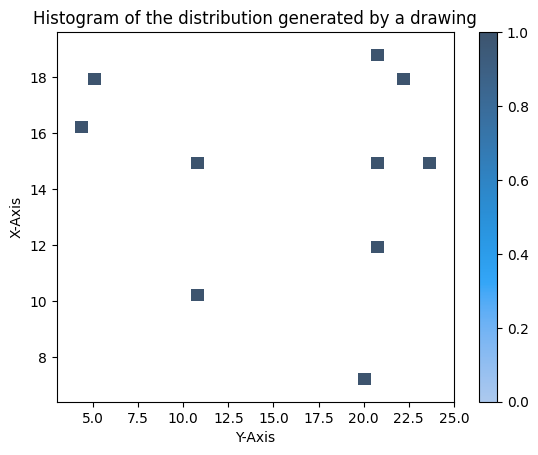

In [11]:
plot_histogram_from_points(x[:10], histplot_kwargs=dict(bins=28))
plt.show()

# Probando clase `AlternativeMetropolisPosteriorPiN` datos originales

En esta sección se intentará simular la implementación del algoritmo de *Metropolis* programado en el notebook 05.

In [12]:
%%time
mcmc = AlternativeMetropolisPosteriorPiN(data=x[:10], models=faces_original, seed=rng)

CPU times: total: 438 ms
Wall time: 437 ms


Muestreamos a partir de de esta instancia.

In [13]:
%%time
mcmc.rvs(size=1_000)
mcmc

CPU times: total: 406 ms
Wall time: 408 ms


AlternativeMetropolisPosteriorPiN(n_data=10, n_models=3393, n_samples=1000, last_i=243)

Y mostramos las caras en orden de la más común a la menos común

In [14]:
plot_list_of_draws(mcmc.most_common(), labels=freq_labels_posterior(mcmc))

# Probando clase `GibbsPosteriorPiN` datos originales

Hacemos lo mismo, pero para la clase `GibbsPosteriorPiN`.

In [15]:
%%time
mcmc = GibbsPosteriorPiN(data=x[:10], models=faces_original, seed=rng)

CPU times: total: 359 ms
Wall time: 366 ms


Muestreamos a partir de de esta instancia.

In [16]:
%%time
mcmc.rvs(size=1_000)
mcmc

CPU times: total: 16.9 s
Wall time: 16.9 s


GibbsPosteriorPiN(n_data=10, n_models=161666, n_samples=1000, last_i=82423, likelihood_sum=2.8442e-21)

In [17]:
plot_list_of_draws(mcmc.most_common(),
                   labels=freq_labels_posterior(mcmc)
                   )

# Probando clase `AlternativeGibbsPosteriorPiN` datos originales

Hacemos lo mismo, pero para la clase `GibbsPosteriorPiN`.

In [18]:
%%time
mcmc = AlternativeGibbsPosteriorPiN(data=x[:10], models=faces_original, seed=rng)

CPU times: total: 453 ms
Wall time: 461 ms


Muestreamos a partir de de esta instancia.

In [19]:
%%time
mcmc.rvs(size=1_000)
mcmc

CPU times: total: 484 ms
Wall time: 501 ms


AlternativeGibbsPosteriorPiN(n_data=10, n_models=3393, n_samples=1000, last_i=933, likelihood_sum=2.8442e-21)

In [20]:
plot_list_of_draws(mcmc.most_common(), labels=freq_labels_posterior(mcmc))

# Probando clase `MetropolisPosteriorPiN` datos modificados

En esta sección se intentará simular el algoritmo de *Metropolis* programado en el notebook 06, el que posee los datos modificados con soporte no-nulo.

In [21]:
%%time
mcmc = MetropolisPosteriorPiN(data=x[:10], models=faces_modified, seed=rng)

CPU times: total: 9.98 s
Wall time: 10.1 s


Muestreamos a partir de de esta instancia.

In [22]:
%%time
mcmc.rvs(size=1_000)
mcmc

CPU times: total: 17.7 s
Wall time: 17.8 s


MetropolisPosteriorPiN(n_data=10, n_models=161666, n_samples=1000, last_i=114983)

In [23]:
plot_list_of_draws(mcmc.most_common(), labels=freq_labels_posterior(mcmc))

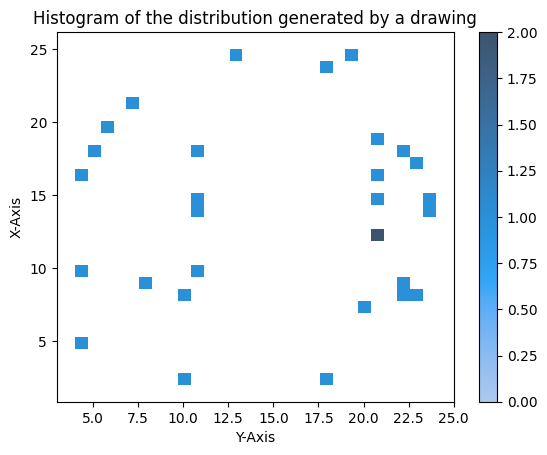

In [24]:
plot_histogram_from_points(x[:30], histplot_kwargs=dict(bins=28))
plt.show()

# Probando clase `GibbsPosteriorPiN` datos modificados

Probamos el algoritmo de Gibbs utilizando los datos modificados.

In [8]:
%%time
mcmc = GibbsPosteriorPiN(data=x[:30], models=faces_modified, seed=rng)

CPU times: total: 14.4 s
Wall time: 16 s


In [14]:
import time

tic = time.time()
mcmc = GibbsPosteriorPiN(data=x[:30], models=faces_modified, seed=rng)
toc = time.time()

print(f"Tiempo cálculo de caché: {toc - tic:.4f} [seg]")

tic = time.time()
toc = time.time()
while toc - tic <= 1:
    mcmc.draw()
    toc = time.time()

mcmc.counter.total()

Tiempo cálculo de caché: 6.4603 [seg]


63

Muestreamos a partir de de esta instancia.

In [26]:
%%time
mcmc.rvs(size=1_000)
mcmc

CPU times: total: 18 s
Wall time: 18.1 s


GibbsPosteriorPiN(n_data=30, n_models=161666, n_samples=1000, last_i=0, likelihood_sum=1.3242e-77)

Notamos que el algoritmo tiene especial preferencia para la primera cara. Esto tiene sentido, pues es de donde se obtuvieron los datos. Sin embargo, por esta misma razón, se intentará correr el algoritmo con los otros datos, excluyendo la primera cara.

In [27]:
plot_list_of_draws(mcmc.most_common(), labels=freq_labels_posterior(mcmc))

# `GibbsPosteriorPiN` con los datos modificacos, sin el primer dibujo

In [28]:
%%time
mcmc = GibbsPosteriorPiN(data=x[:30], models=faces_modified[1:], seed=rng)

CPU times: total: 3.28 s
Wall time: 3.28 s


Muestreamos a partir de de esta instancia.

In [29]:
%%time
mcmc.rvs(size=1_000)
mcmc

CPU times: total: 17.9 s
Wall time: 17.9 s


GibbsPosteriorPiN(n_data=30, n_models=161665, n_samples=1000, last_i=11134, likelihood_sum=5.0874e-78)

In [30]:
plot_list_of_draws(mcmc.most_common(), labels=freq_labels_posterior(mcmc))

Notamos que ahora los sampleos se encuentran más "equilibrados". Ahora nos interesaremos en un test de "estrés", querremos probar con $n$ alto.

# `GibbsPosteriorPiN` con $n=50$ sin la primera cara

In [31]:
%%time
mcmc = GibbsPosteriorPiN(data=x[:50], models=faces_modified[1:], seed=rng)

CPU times: total: 5.31 s
Wall time: 5.33 s


Muestreamos a partir de de esta instancia.

In [32]:
%%time
mcmc.rvs(size=1_000)
mcmc

CPU times: total: 18.3 s
Wall time: 18.4 s


GibbsPosteriorPiN(n_data=50, n_models=161665, n_samples=1000, last_i=128552, likelihood_sum=3.2956e-132)

In [33]:
faces_modified[0]

In [34]:
plot_list_of_draws(mcmc.most_common(), labels=freq_labels_posterior(mcmc))

# `GibbsPosteriorPiN` con $n=100$ sin la primera cara

In [35]:
%%time
mcmc = GibbsPosteriorPiN(data=x, models=faces_modified[1:], seed=rng)

CPU times: total: 11.3 s
Wall time: 11.3 s


Muestreamos a partir de de esta instancia.

In [36]:
%%time
mcmc.rvs(size=1_000)
mcmc

CPU times: total: 17.6 s
Wall time: 17.6 s


GibbsPosteriorPiN(n_data=100, n_models=161665, n_samples=1000, last_i=71038, likelihood_sum=9.0517e-267)

In [37]:
faces_modified[0]

In [38]:
plot_list_of_draws(mcmc.most_common(), labels=freq_labels_posterior(mcmc))

# `GibbsPosteriorPiN` con $n=100$ sin la primera cara

In [39]:
%%time
mcmc = GibbsPosteriorPiN(data=x, models=faces_original, seed=rng)

CPU times: total: 2.06 s
Wall time: 3.76 s


C:\Users\asoln\PycharmProjects\PersonalProjects\Bayesian-Learning-with-Wasserstein-Barycenters\bwb\distributions.py:267: UserWarning: The likelihood support has only one element.
  warnings.warn("The likelihood support has only one element.")


Muestreamos a partir de de esta instancia.

In [40]:
%%time
mcmc.rvs(size=1_000)
mcmc

CPU times: total: 16.4 s
Wall time: 16.5 s


GibbsPosteriorPiN(n_data=100, n_models=161666, n_samples=1000, last_i=0, likelihood_sum=3.9950e-238)

In [41]:
faces_modified[0]

In [42]:
plot_list_of_draws(mcmc.most_common(), labels=freq_labels_posterior(mcmc))